# Disclaimer

This is an experiment in testing whether enough information can be gained from short reads of DNA to produce a piece of information that can be used to re-identify individuals. The answer seems to be positive even for something 2 read locations (providing at maximum 400 bits) under a set of (very strong) simplifying assumptions suitable for a one-day demo.

- We can retrieve 100 base pairs from a given location(s)
- It's possible to do this from 1-5 locations
- We assume the reader has a 1/100 failure rate and the data is corrupted randomly and independently
- We assume that people differ in at least 20% of the genetic material
- We assume that the user supplies an actual sample
- We want to be able to generate an ephemeral set of information that re-identifies the user to one application.

Note that the current construction is not suitable for use in a security context as the security properties have not been investigated and several risks are clearly on the table:

- the distribution of genome letters may not be uniform at a given read site, reducing the security of the scheme (the reduction depends on the amount of structure)
- at the moment the salt must be kept secret, if an attacker gets access to the salt, they may start to try and brute force the original genetic information (steps have not been taken to prevent this)
- if multiple salts and thus "mappings" of the genetic data are available to the attacker, the situation may be considerably worse.



In [1]:
import hashlib
import random
import numpy as np
from typing import List
import matplotlib.pyplot as plt

In [2]:
def make_random_dna(count: int) -> str:
    return "".join(map(lambda x: random.choice('ATCG'), range(count)))

In [3]:
def perturb_random_dna(dna: str, error_rate: float) -> str:
    result = []
    for letter in dna:
        result.append(random.choice('ATCG'.replace(letter, '')) if random.uniform(0.0, 1.0) < error_rate else letter)
    return "".join(result)

In [4]:
def differences(dna1: str, dna2: str) -> int:
    diffs = 0
    for l1, l2 in zip(dna1, dna2):
        diffs += 1 if l1 != l2 else 0
    return diffs

In [5]:
test = make_random_dna(50)
test

'CGAGTCTTCAGTGCTTACAGTGGAACTCTAATAGATTAGCCAGACTGCTT'

In [6]:
perturbed = perturb_random_dna(test, 0.1)
perturbed

'CGAGTCTTCAGTGCATACAGTGGAACTCTAATCTATTAGACAGACTGCTT'

In [7]:
differences(test, perturbed)

4

In [8]:
def derive_hashset(dna: str, salt: str, size: int) -> List[int]:
    hashes = []
    for i in range(0, len(dna), size):
        dna_masked = dna[i:i+size] + salt
        hashes.append(hashlib.sha256(dna_masked.encode('ascii')).hexdigest()[:4])
    return hashes

In [9]:
hs1 = derive_hashset(test, 'thisismysalt', 5)
print(hs1)

['8858', '19ab', 'a59e', '50fc', '1e8d', 'fb14', '6542', '11cf', '1ae6', '7638']


In [10]:
hs2 = derive_hashset(perturbed, 'thisismysalt', 5)
print(hs2)

['8858', '19ab', '1cb2', '50fc', '1e8d', 'fb14', 'da5f', 'cbdf', '1ae6', '7638']


In [11]:
def compute_hashset_matches(hs1: List[str], hs2: List[str]) -> int:
    matches = 0
    for h1, h2 in zip(hs1, hs2):
        matches += 1 if h1 == h2 else 0
    return matches

In [12]:
compute_hashset_matches(hs1, hs2)

7

# Simple simulator

In [13]:
reference_dna = make_random_dna(300)
reference_dna

'GTTGGTCGCTCTGAAGTCGTACCTCGCTGCGTGTAAACGCCTATTTACCAGACGCAAACAGACTTGTAAACCTTGCGGTGAGTTGGCTCGTAGGAAAACGTCCCAAGTGATTAAGTGATCGCTCTTCCTACTTACGTACGGACGTGCAAACTATACAAAGTCTCTTCTGAAGTCCCATATCTCCATAAAGAGAAAAGTTAGGCCCGCGCTAGTAAAGCAACCTTTATACTACTTAGCATCTAATCACTTCAGATTAATTTAGGACCATCCTGTTACTCTTATCGTTCAGATTGTGGCGTA'

In [14]:
salt = 'thisismysalt'
crib_size = 5
crib_count = 300 / crib_size
reference_hashset = derive_hashset(reference_dna, 'thisismysalt', crib_size)
runs = 100000
device_error_rate = 0.01
population_diff_rate = 0.2

print(reference_hashset)

['9885', '5cae', '7dee', '2ba1', '55b1', '5447', 'c253', 'fcfa', 'cf4b', 'c961', 'd859', '4032', '1707', '89d9', '82e9', 'eb46', '4166', 'e3a4', '1217', 'f1c1', '0137', 'd615', 'a9f8', '9dd2', '53e5', '9a3c', 'c05a', 'b895', 'f90b', '809c', 'f2dd', '5a68', '0cc9', '350d', '3bfe', '83e9', 'cae8', 'b305', 'c51c', '8490', '0eb2', 'b458', '15eb', 'fd72', '5269', 'f3ca', 'd147', '0755', 'f6f5', '7b22', '9277', '389c', '0079', '87f6', '9914', 'f066', '8856', '5865', '43e9', 'faa8']


In [15]:
# test matcher TP rate
tp_matches = []
for i in range(runs):
    dna_with_error = perturb_random_dna(reference_dna, device_error_rate)
    hashset_from_error = derive_hashset(dna_with_error, salt, crib_size)
    tp_matches.append(compute_hashset_matches(reference_hashset, hashset_from_error))
    
print(tp_matches[:10])

tp_matches_np = np.array(tp_matches)
print('TP matches with max 1 error : {}'.format(sum(tp_matches_np >= crib_count - 1)))
print('TP matches with max 2 errors: {}'.format(sum(tp_matches_np >= crib_count - 2)))
print('TP matches with max 3 errors: {}'.format(sum(tp_matches_np >= crib_count - 3)))
print('TP matches with max 4 errors: {}'.format(sum(tp_matches_np >= crib_count - 4)))
print('TP matches with max 8 errors: {}'.format(sum(tp_matches_np >= crib_count - 8)))

[59, 59, 56, 57, 57, 60, 57, 56, 52, 60]
TP matches with max 1 error : 19999
TP matches with max 2 errors: 43090
TP matches with max 3 errors: 66168
TP matches with max 4 errors: 83017
TP matches with max 8 errors: 99726


In [16]:
# test matcher FP rate
fp_matches = []
for i in range(runs):
    different_dna = perturb_random_dna(reference_dna, population_diff_rate)
    hashset_from_other_dna = derive_hashset(different_dna, salt, crib_size)
    fp_matches.append(compute_hashset_matches(reference_hashset, hashset_from_other_dna))

fp_matches_np = np.array(fp_matches)
print('FP matches with max 1 error : {}'.format(sum(fp_matches_np >= crib_count - 1)))
print('FP matches with max 2 errors: {}'.format(sum(fp_matches_np >= crib_count - 2)))
print('FP matches with max 3 errors: {}'.format(sum(fp_matches_np >= crib_count - 3)))
print('FP matches with max 4 errors: {}'.format(sum(fp_matches_np >= crib_count - 4)))
print('FP matches with max 8 errors: {}'.format(sum(fp_matches_np >= crib_count - 8)))

print('Other-DNA matches with > k matches')
for k in range(1, 15):
    print('Hits with at least {} matches: {}'.format(k, sum(fp_matches_np > k)))

FP matches with max 1 error : 0
FP matches with max 2 errors: 0
FP matches with max 3 errors: 0
FP matches with max 4 errors: 0
FP matches with max 8 errors: 0
Other-DNA matches with > k matches
Hits with at least 1 matches: 100000
Hits with at least 2 matches: 100000
Hits with at least 3 matches: 100000
Hits with at least 4 matches: 100000
Hits with at least 5 matches: 99999
Hits with at least 6 matches: 99997
Hits with at least 7 matches: 99980
Hits with at least 8 matches: 99950
Hits with at least 9 matches: 99846
Hits with at least 10 matches: 99564
Hits with at least 11 matches: 98992
Hits with at least 12 matches: 97815
Hits with at least 13 matches: 95680
Hits with at least 14 matches: 92369


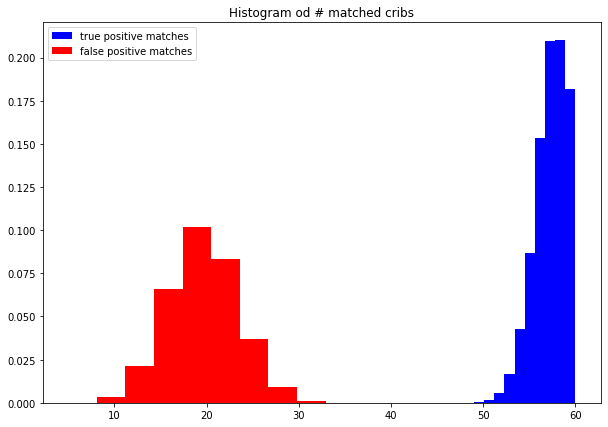

In [17]:
plt.figure(figsize=(10,7))
#counts, bin_edges = np.histogram(tp_matches, bins=int(crib_count)+1, normed=True)
#tp_cdf = np.cumsum(counts) / np.sum(counts)
#plt.plot(bin_edges[1:], tp_cdf, color='blue')

plt.hist(tp_matches, color='blue', density=True)
#counts, bin_edges = np.histogram(fp_matches, bins=int(crib_count)+1, normed=True)
#fp_cdf = np.cumsum(counts) / np.sum(counts)
#plt.plot(bin_edges[1:], fp_cdf, color='red')

plt.hist(fp_matches, color='red', density=True)
plt.legend(['true positive matches', 'false positive matches'])
plt.title('Histogram od # matched cribs');

In [18]:
# Example data
for i in range(50):
    print(make_random_dna(100))

TGTCCACTTTCGCAGCTGTCAGTGTGGTCCGCGATGCACCTGTGCCCTCTCTGCGCAGACTGACTCGACTGCACTTAGGCTATAGGGAGACGCTGATTGC
CTTGGACGTAACGTCACTCTAGGCATCCGTTCGGATACGTCGCTGGGCTCAAGAATGATCTCCACGAATACAAACCTATGAAACATCGGTCATAGGCTGC
GCTGGTCGTGCTCTCCCTAGCAAACCGGCTGAAGTGGCTAGAATCTGTTAATTAAAAGTAATCCTGTGAGTAATTCCATCTCTCTCTGGTCTCTACGTAT
CTCATCCGCCTGCAGTAAGGGAGCCAAAGCTGAGGGTCTGCGTTGTGGGAACGACACTTATAAGGCGGTGAGTTACACTCGTCAGCTCTCCCTCTTGTAG
ATTTAGACGAAGCCCTCGGTCGACCCTGAACCGCGATGAGGGCGACCCAGCTGTAGCCGAACATGTTAAGGTGGAATACTTGGTCGCTCTTACCTCGGTG
TGACGATTTTTCTCAAAAACTTCTGGCTTTCATGCCATCCATCTTAGGCTAATGTTGCCGTTAAACCTCTTAGTCACCCCTGACAAAGCTCCAGCGATCA
GCGTTTGAACGCAACGTCCTATTCCTTATCGGTGTAAAATACGGGCCCATCTTTGCCGTCTGCAATGACGGAGCTGCGTGACTATACCATGAAGAATAAG
CACTTAGCTCTTCGGTCGGCATACCCAGGCTCGCTAGGGGTTTCTCTGCCAGAGAGTTCTGGTAATGTATGAGGAGGCAAGTTGTCGCATGCTGAACTTA
AGCACTCGTCCGTATCACTCAGTAAACAGTTATCCGTTGATAAGACGAACTGAGCGTTGCTCTTAAAGCAAGAATACAACTACTCCATGGGCGCGATGAC
GCTGTGGGACCCTTTTCAACTTCACGTCTTTCCCATACATTCCAGACAGAAAGGATAGCCTCGGGCTATGCTACCCCACGGGTCTTTAGCT